In [27]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai') 
import numpy as np
import pandas as pd
from sklearn import svm

In [28]:
train = pd.read_csv("./train_origin.csv")
test = pd.read_csv("./test_origin.csv")
print(train.describe())

         train_id       max_h       min_h      mean_h        sd_h  \
count  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    50.500000   31.256400   13.551000   25.116951    4.080438   
std     29.011492    6.669115    7.094876    6.062526    1.764470   
min      1.000000   21.010000    5.100000   14.525690    0.520348   
25%     25.750000   25.505000    8.372500   20.403993    2.917439   
50%     50.500000   30.705000   11.980000   23.497401    3.866057   
75%     75.250000   35.872500   16.355000   29.329508    5.200860   
max    100.000000   47.230000   38.259998   40.867333    9.411008   

              sum_h  crown_area  crown_perim         dbh  
count    100.000000   100.00000   100.000000  100.000000  
mean    3434.404894    22.13120    25.992000   40.280000  
std     2177.420502    12.88846     9.234451   13.447301  
min      243.139998     2.08000     1.600000   14.500000  
25%     1873.557498    12.28000    20.800000   29.875000  
50%     3170.640000    2

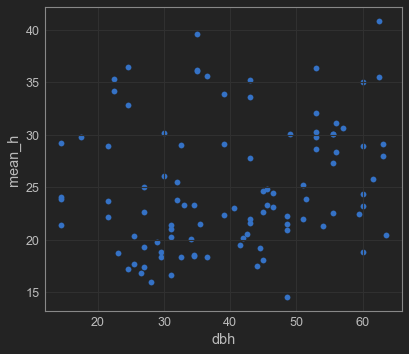

In [29]:
import matplotlib.pyplot as plt
x = train["dbh"]
y = train["mean_h"]
plt.scatter(x,y)
plt.xlabel("dbh")
plt.ylabel("mean_h")
plt.show()

In [30]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

target = train["dbh"]
train = train.drop(["dbh", "train_id"],axis=1)
test_target = test["test_id"]
test = test.drop(["test_id"],axis=1)

In [61]:
%%time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

kf = KFold(n_splits=100,random_state=0)
param = {
        "booster": "gblinear",
        "max_depth": 3,
        "eta": 0.1,
        "objective": "reg:squarederror",
    }
num_round = 250

results = []
dist = []
for X_index, Y_index in kf.split(train):
    X_train, X_target = train.loc[X_index], target.loc[X_index]
    Y_train, Y_target = train.loc[Y_index], target.loc[Y_index]
    
    dtrain = xgb.DMatrix(pd.DataFrame(X_train), label=pd.DataFrame(X_target))
    dvalid = xgb.DMatrix(pd.DataFrame(Y_train), label=pd.DataFrame(Y_target))
    
    bst = xgb.train(
                            param, dtrain,
                            num_round,
    )
    pred = bst.predict(dvalid)
    results.append(np.sqrt(mean_squared_error(Y_target,pred)))
    dist.append((pred-Y_target).values)
print(np.array(results).mean())

C:\Users\owner\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


11.519739151000977
Wall time: 4.7 s


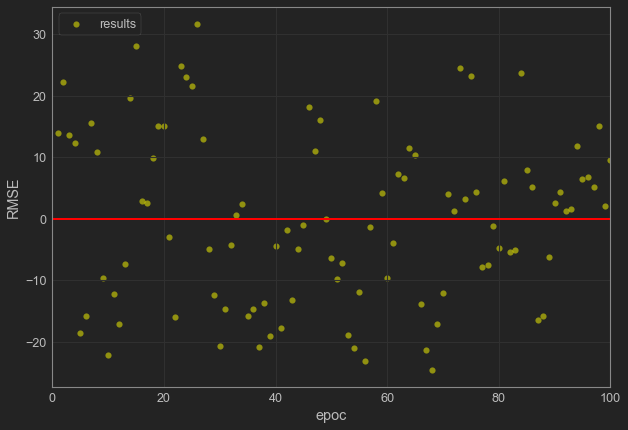

In [62]:
dists = np.array(dist)
plt.figure(figsize = (10, 7))
plt.scatter(range(1,101), dist, c = 'yellow', marker = 'o', s = 35, alpha = 0.5, label = 'results')
plt.xlabel('epoc')
plt.ylabel('RMSE')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 100, lw = 2, color = 'red')
plt.xlim([0, 100])
plt.show()

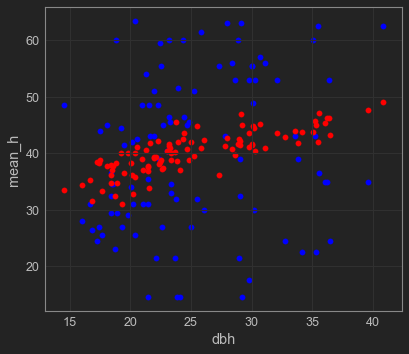

In [63]:
plt.scatter(train["mean_h"],target,color="blue")
plt.scatter(train["mean_h"],bst.predict(xgb.DMatrix(pd.DataFrame(train))),color="red")
plt.xlabel("dbh")
plt.ylabel("mean_h")
plt.show()

In [64]:
dtest = xgb.DMatrix(test)
pred = pd.DataFrame()
pred["Id"] = test_target
pred["dbh"] = (bst.predict(dtest)).round(2)
pred.to_csv("DBH_xgblinear.csv", index=False)